# Explore subreddit graph
Let's look at the graph of subreddits that we collected from comment cross-posting.

In [1]:
import pandas as pd
subreddit_comment_graph = pd.read_csv('../../data/reddit_data/comment_2019-01_cross_posting.gz', sep='\t', compression='gzip', index_col=False)
subreddit_comment_graph.drop('Unnamed: 0', axis=1, inplace=True)
print(subreddit_comment_graph.shape)
display(subreddit_comment_graph.head())

(28527789, 3)


,subreddit_i,subreddit_j,count
0,AskDocs,TooAfraidToAsk,33
1,EverspaceGame,Minecraft,2
2,EverspaceGame,MinecraftSwitch,1
3,EverspaceGame,NintendoSwitch,1
4,EverspaceGame,OXENFREE,1


In [2]:
display(subreddit_comment_graph.sort_values('count', inplace=False, ascending=False).head())

,subreddit_i,subreddit_j,count
879,Market76,fo76,1194
2009,AgeplayPenPals,dirtypenpals,1103
548,Market76,fo76bazaar,807
1000,fo76,fo76bazaar,699
475,NoStupidQuestions,unpopularopinion,690


In [3]:
## convert to weighted undirected network
from networkx import Graph
subreddit_graph = Graph()
edge_data = subreddit_comment_graph.apply(lambda x: (x.loc['subreddit_i'], x.loc['subreddit_j'], {'weight':x.loc['count']}), axis=1).values
subreddit_graph.add_edges_from(edge_data)
# for idx_i, data_i in subreddit_comment_graph.iterrows():
#     subreddit_graph.add_edge((data_i))

In [4]:
len(subreddit_graph)

59071

In [5]:
test_node = 'AmItheAsshole'
test_edges = list(subreddit_graph.neighbors(test_node))
print(test_edges[:10])

['cardistry', 'magicTCG', 'yugioh', 'HaveWeMet', 'TwoSentenceHorror', 'answers', 'dadjokes', 'findareddit', 'fireemblem', 'tipofmytongue']


### Find communities
Let's look for consistent communities in the graph.

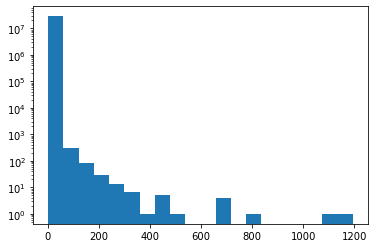

In [24]:
## plot edge weight distribution
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
subreddit_graph_edges = np.array(subreddit_graph.edges())
subreddit_graph_edge_weights = np.array([subreddit_graph.get_edge_data(*e)['weight'] for e in subreddit_graph_edges])
plt.hist(subreddit_graph_edge_weights, bins=20)
plt.yscale('log')
plt.show()

Most subreddits have weak connections. Let's try to prune those!

In [69]:
edge_weight_cutoff_pct = 99.9
edge_weight_cutoff = np.percentile(subreddit_graph_edge_weights, edge_weight_cutoff_pct)
print(f'edge weight cutoff = {edge_weight_cutoff}')
subreddit_graph_edges_cutoff = subreddit_graph_edges[np.where(subreddit_graph_edge_weights > edge_weight_cutoff)[0]]
print(f'{len(subreddit_graph_edges_cutoff)}/{len(subreddit_graph_edges)} edges retained after pruning')
prune_subreddit_graph = Graph()
for edge_i in subreddit_graph_edges_cutoff:
    weight_i = subreddit_graph.get_edge_data(*edge_i)['weight']
    prune_subreddit_graph.add_edge(*edge_i, weight=weight_i)

edge weight cutoff = 5.0
24737/28527789 edges retained after pruning


In [50]:
print(len(prune_subreddit_graph))

4941


In [51]:
## identify giant component
from networkx import connected_components
subreddit_connected_components = connected_components(prune_subreddit_graph)
subreddit_giant_component = list(sorted(subreddit_connected_components, key=len, reverse=True))[0]
subreddit_main_graph = subreddit_graph.subgraph(subreddit_giant_component)

In [52]:
print(len(list(connected_components(subreddit_graph))))
print(len(subreddit_main_graph))

1242
4645


In [53]:
import community # Louvain takes ~ 10 mins
# from networkx.algorithms.community.modularity_max import greedy_modularity_communities
# subreddit_graph_partition = list(greedy_modularity_communities(subreddit_graph))
subreddit_graph_partition = community.best_partition(subreddit_main_graph, weight='weight')

In [54]:
print(len(subreddit_graph_partition))

4645


In [55]:
# convert to community sets
from collections import defaultdict
subreddit_communities = defaultdict(set)
for subreddit_i, id_i in subreddit_graph_partition.items():
    subreddit_communities[id_i].add(subreddit_i)

In [56]:
subreddit_communities_by_size = list(sorted(subreddit_communities.keys(), key=lambda x: len(subreddit_communities.get(x)), reverse=True))
print(len(subreddit_communities[subreddit_communities_by_size[0]]))
# print(list(sorted(subreddit_communities[subreddit_communities_by_size[0]])))

2433


In [57]:
advice_subreddits = ['Advice', 'AmItheAsshole', 'pcmasterrace', 'legaladvice', 'personalfinance']
for advice_subreddit in advice_subreddits:
    print(subreddit_graph_partition[advice_subreddit])

6
6
3
6
6


Most of the advice subreddits end up in the same community.

### Normalize weights
Let's normalize the edge weights by what % of each subreddit's out-degree.

- A-B have 100 users
- A-C have 30 users
- B-C have 10 users

- A-B normalized =  1/2*(100/130 + 100/110) = 84%
- A-C normalized = 1/2*(30/130 + 30/40) = 49%
- B-C normalized = 1/2*(30/130 + 30/40) = 17%

In [74]:
# get combined weights
subreddit_combined_weights = {n : sum([prune_subreddit_graph.get_edge_data(n, n1)['weight'] for n1 in prune_subreddit_graph.neighbors(n)]) for n in prune_subreddit_graph.nodes()}
print(subreddit_combined_weights['Advice'])
# normalize lol
def compute_norm_edge_weight(n1, n2, weight, combined_weights):
    norm_weight = 0.5 * (weight / combined_weights[n1] + weight / combined_weights[n2])
    return norm_weight
subreddit_norm_edge_data = [(n1, n2, {'weight' : compute_norm_edge_weight(n1, n2, prune_subreddit_graph.get_edge_data(n1, n2)['weight'], subreddit_combined_weights)}) for n1, n2 in prune_subreddit_graph.edges()]
import networkx
norm_weight_subreddit_graph = networkx.from_edgelist(subreddit_norm_edge_data)

8343


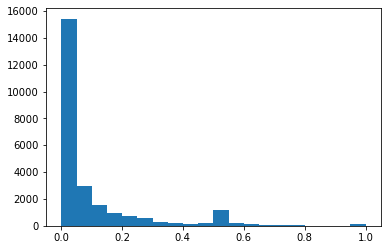

In [78]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
norm_weights = [norm_weight_subreddit_graph.get_edge_data(*e)['weight'] for e in norm_weight_subreddit_graph.edges()]
plt.hist(norm_weights, bins=20)
plt.show()

Most subreddits have weak cross-posting connections. We also have a bump around 0.5, suggesting that some subreddits with low degree have strong connections with half of their neighbors.

Next step: let's look for the top-K neighbors for each of the subreddits of interest.

In [81]:
advice_subreddits = ['Advice', 'AmItheAsshole', 'personalfinance', 'legaladvice', 'pcmasterrace']
top_k = 10
for subreddit_i in advice_subreddits:
    neighbors_i = norm_weight_subreddit_graph.neighbors(subreddit_i)
    neighbor_weights_i = [(n_j, norm_weight_subreddit_graph.get_edge_data(subreddit_i, n_j)['weight']) for n_j in neighbors_i]
    neighbor_weights_i = list(sorted(neighbor_weights_i, key=lambda x: x[1], reverse=True))
    print(f'subreddit={subreddit_i}, neighbors={neighbor_weights_i[:top_k]}')

subreddit=Advice, neighbors=[('helpme', 0.500659235287067), ('MMFB', 0.5004195133644972), ('domesticviolence', 0.5004195133644972), ('Adulting', 0.5004195133644972), ('LifeAdvice', 0.36459525132664294), ('work', 0.32577909624835194), ('PlasticSurgery', 0.2817893743257821), ('education', 0.2504195133644972), ('MadeMeSmile', 0.25035958288385474), ('CleaningTips', 0.23112881365308552)]
subreddit=AmItheAsshole, neighbors=[('pettyrevenge', 0.13075757033217555), ('skiing', 0.11635142170108333), ('MaliciousCompliance', 0.10655223298336075), ('badroommates', 0.0914502094747019), ('entitledparents', 0.06441483308190142), ('Herpes', 0.04444506718603315), ('TalesFromYourServer', 0.041289075088623915), ('vancouver', 0.04045378339917514), ('relationship_advice', 0.039799374560282694), ('omad', 0.0394283447780064)]
subreddit=personalfinance, neighbors=[('Birmingham', 0.5007266385699753), ('consulting', 0.5005813108559802), ('Dashcam', 0.5005813108559802), ('nashville', 0.5005086469989827), ('tulsa',

Most of the top-K neighbors are relevant, but some of them are definitely off the mark:
- `Advice`: `Adulting` relevant, `PlasticSurgery` irrelevant
- `AmItheAsshole`: `pettyrevenge` relevant, `skiing` irrelevant
- `personalfinance`: `consulting` relevant, `Birmingham` irrelevant
- `legaladvice`: `AusLegal` relevant, `Charlotte` irrelevant
- `pcmasterrace`: `LinusTechTips` relevant, `nier` irrelevant